# 2D MT forward modelling

## Learning goals

- Identify Transverse Electric (TE) and Transverse Magnetic (TM) modes.
- Understand how to design mesh. 
- Understand **spatial features** of the transfer function in the form of apparent resistivity and phase
- Explore how the transfer function varies with **frequency**


In [7]:
import discretize
from discretize import utils as dis_utils
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import utils, maps
import numpy as np
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from geoana.em.fdem import skin_depth
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.rcParams['font.size'] = 14

In [8]:
d_station = 4 * 1e3
n_rx = 26
x = np.arange(n_rx) * d_station - 50 * 1e3
lx = x.max() - x.min()
rx_locs = np.c_[x, np.zeros(n_rx)]
frequencies = np.logspace(-2, 2, 20)
n_freq = len(frequencies)

## Step 1: Discretize the domain using a 2D `Tensor` Mesh

### How we set up `padding cells` for satisfying the boundary condition?

In [9]:
# Setting the smallest cell size in z-direction
sig_background = 1e-2
f_min = 1e-2
f_max = 1e2
factor_min = 5
factor_max = 6
dz_min = skin_depth(100, sig_background) / factor_max
print ("Suggested smallest cell size is: {:.1f} m".format(dz_min))

Suggested smallest cell size is: 83.9 m


### Design cells in vertical direction

In [10]:
print ("Suggested vertical dimension length is: {:.1f}km".format(skin_depth(sig_background, f_min) / 1e3 * factor_max))

Suggested vertical dimension length is: 302.0km


In [11]:
nz_down = 33
pfz_up = 1.2
hz_down = dz_min*pfz_up**np.arange(nz_down)[::-1]
print (hz_down.sum() / 1e3)

171.61685483207947


In [12]:
pfz_up = 1.5
npadz = 5
hz_up = [(dz_min, npadz, pfz_up)]
hz_up = dis_utils.meshTensor(hz_up)
print (hz_up.sum() / 1e3)
hz = np.r_[hz_down, hz_up]

1.6592912111181681


C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\discretize\utils\code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


### Design cells in lateral dimension

In [13]:
factor_spacing = 4
dx_min = d_station/factor_spacing
csx = np.round(dx_min)
# print (csx)
ncx = int(lx / csx)
npadx = 11
pfx = 1.5
hx_pad = dis_utils.meshTensor([(dx_min, npadx, -pfx)])
print (hx_pad.sum()/1e3)
hx = [(dx_min, npadx, -pfx), (dx_min, ncx), (csx, npadx, pfx)]

256.49267578125


In [14]:
mesh = discretize.TensorMesh([hx, hz])
mesh.origin = np.r_[-mesh.hx[:npadx].sum()+rx_locs[:,0].min(), -hz_down.sum()]

C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\discretize\base\base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(


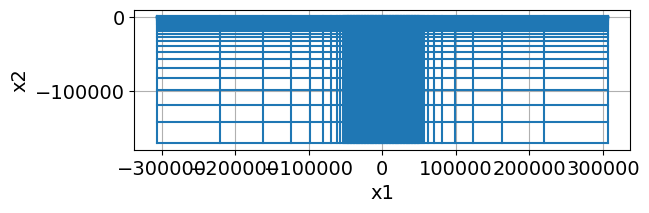

In [15]:
mesh.plot_grid()
plt.gca().set_aspect(1)

### Put all things together to generate a mesh

In [16]:
def generate_2d_mesh_for_mt(
    rx_locs, frequencies, sigma_background, 
    z_factor_max=5, 
    z_factor_min=5,
    pfz_down = 1.2,
    pfz_up = 1.5,
    npadz_up = 5,
    x_factor_max = 2,
    spacing_factor = 4,
    pfx = 1.5,
    n_max=1000
):
    # Setting the cells in depth dimension
    f_min = frequencies.min()
    f_max = frequencies.max()
    dz_min = np.round(skin_depth(f_max, sigma_background) / z_factor_max) 
    lz = skin_depth(sig_background, f_min) * z_factor_max
    # Setting the domain length in z-direction
    for nz_down in range(n_max):
        hz_down = dz_min*pfz_down**np.arange(nz_down)[::-1]
        if hz_down.sum()>lz:
            break
    hz_up = [(dz_min, npadz_up, pfz_up)]
    hz_up = dis_utils.unpack_widths(hz_up)
    hz = np.r_[hz_down, hz_up]   
    # Setting the cells in lateral dimension
    d_station = np.diff(rx_locs[:,0]).min()
    dx_min = np.round(d_station/spacing_factor)
    lx = rx_locs[:,0].max() - rx_locs[:,0].min()
    ncx = int(lx / dx_min)
    lx_pad = skin_depth(sig_background, f_min) * x_factor_max
    for npadx in range(n_max):
        hx_pad = dis_utils.meshTensor([(dx_min, npadx, -pfx)])
        if hx_pad.sum()>lx_pad:
            break
    hx = [(dx_min, npadx, -pfx), (dx_min, ncx), (csx, npadx, pfx)]  
    
    mesh = discretize.TensorMesh([hx, hz])
    mesh.origin = np.r_[-mesh.hx[:npadx].sum()+rx_locs[:,0].min(), -hz_down.sum()]   
    print (mesh)
    return mesh
mesh = generate_2d_mesh_for_mt(rx_locs, frequencies, 1e-2)


  TensorMesh: 4,720 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    118   -162,330.08    162,330.08  1,000.00 38,443.36    1.50
   y     40   -297,782.46      1,997.91    101.00 49,714.58    1.50




C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\discretize\utils\code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\discretize\base\base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(


<AxesSubplot:xlabel='x1', ylabel='x2'>

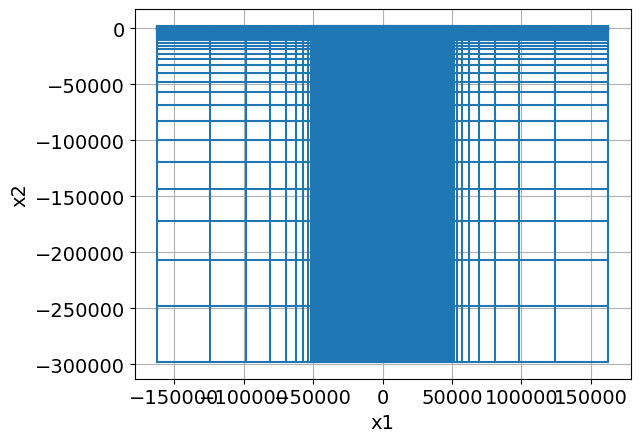

In [17]:
mesh.plot_grid()

## Step 2: Generate a conductivity model

In [18]:
sigma_background = 1e-2
sigma_block = 1e0
sigma_air = 1e-8

cells = mesh.cell_centers
sigma = np.ones(mesh.n_cells) * sigma_background
blk_ind = utils.model_builder.getIndicesBlock(np.r_[-10000, -5000], np.r_[10000, -10000], cells)
sigma[blk_ind] = sigma_block
sigma[cells[:, -1] >= 0] = sigma_air

Text(0, 0.5, 'Elevation (m)')

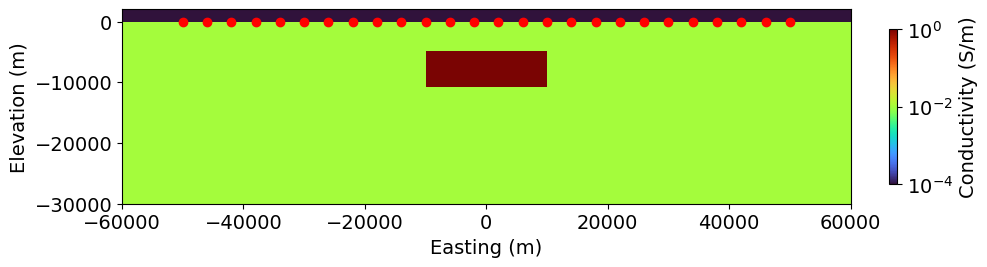

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
grid= False
out = mesh.plot_image(
    sigma, grid=grid, ax=ax, pcolor_opts={'norm':LogNorm(vmin=1e-4, vmax=1), 'cmap':'turbo'},
    range_x=(-60000, 60000), range_y=(-30000, 2000)
)
ax.plot(rx_locs[:,0], rx_locs[:,1], 'ro')
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Conductivity (S/m)")
ax.set_aspect(1)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")


## Step 3: Setup `Survey` and `Simulation`

In [20]:
# simulation class for TE mode
rx_list_tm = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="phase"
    ),
]
src_list_tm = [nsem.sources.Planewave(rx_list_tm, frequency=f) for f in frequencies]
survey_tm = nsem.Survey(src_list_tm)

sim_tm= nsem.simulation.Simulation2DElectricField(
    mesh,
    survey=survey_tm,
    sigma=sigma,
    solver=Solver,
)

# simulation class for TE mode
rx_list_te = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="phase",        
    ),       
]
src_list_te = [nsem.sources.Planewave(rx_list_te, frequency=f) for f in frequencies]
survey_te = nsem.Survey(src_list_te)

sim_te = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey_te,
    sigma=sigma,
    solver=Solver,
)

## Step 4: Run forward modelling

In [21]:
f_te = sim_te.fields()
pred_te = sim_te.dpred(f=f_te)
f_tm = sim_tm.fields()
pred_tm = sim_tm.dpred(f=f_tm)

C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TensorMesh.getInterpolationMat has been deprecated, please use TensorMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [22]:
# extract fields
e_te = f_te[src_list_te[0], 'e']
h_te = f_te[src_list_te[0], 'h']
e_tm = f_tm[src_list_tm[0], 'e']
h_tm = f_tm[src_list_tm[0], 'h']

Text(0, 0.5, 'Elevation (m)')

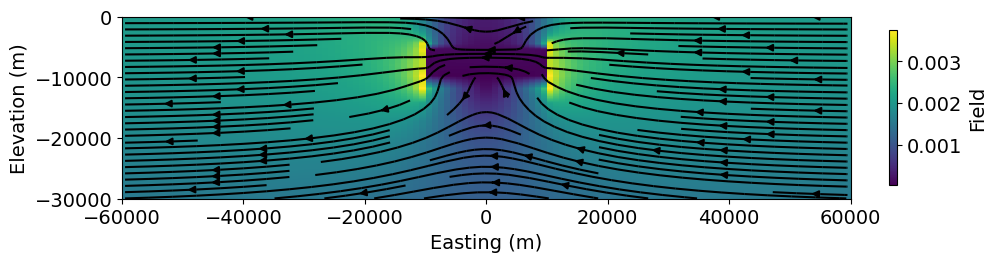

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_image(e_tm.real, v_type='E', view='vec', ax=ax, range_x=(-60000, 60000), range_y=(-30000, 0))
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Field")
ax.set_aspect(1)
ax.set_ylim(-30000, 0)
ax.set_xlim(-60000, 60000)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")

Text(0, 0.5, 'Elevation (m)')

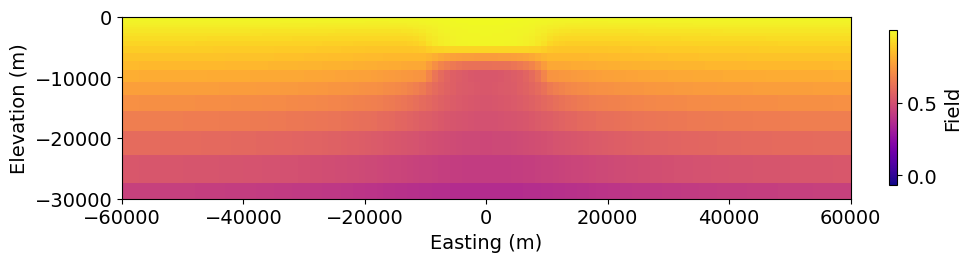

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_image(
    h_tm.real, v_type='CC', ax=ax, range_x=(-60000, 60000), range_y=(-30000, 0),
    pcolor_opts={'cmap':'plasma'}
)
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Field")
ax.set_aspect(1)
ax.set_ylim(-30000, 0)
ax.set_xlim(-60000, 60000)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")

Text(0, 0.5, 'Elevation (m)')

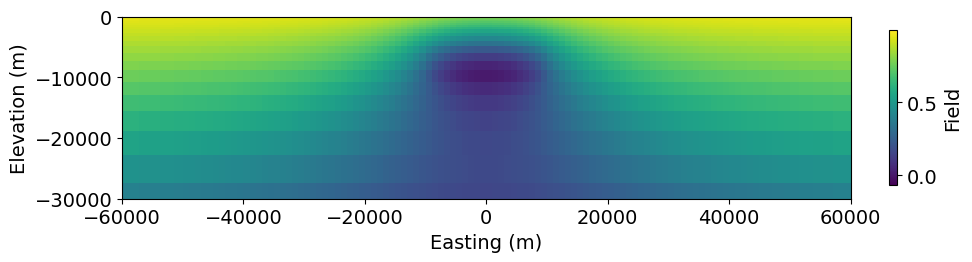

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_image(e_te.real, v_type='CC', ax=ax, range_x=(-60000, 60000), range_y=(-30000, 0))
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Field")
ax.set_aspect(1)
ax.set_ylim(-30000, 0)
ax.set_xlim(-60000, 60000)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")

Text(0, 0.5, 'Elevation (m)')

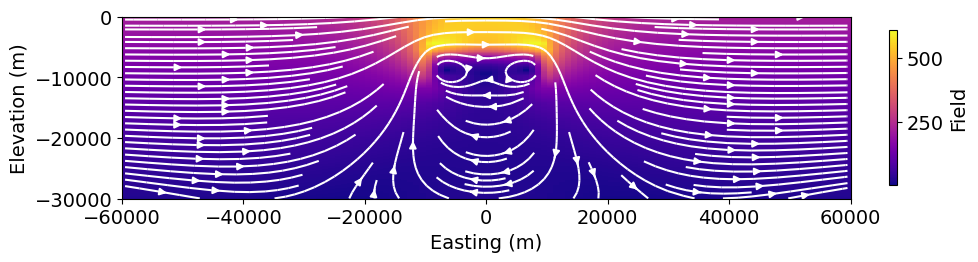

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_image(
    h_te.real, v_type='E', view='vec', ax=ax, range_x=(-60000, 60000), range_y=(-30000, 0),
    pcolor_opts={'cmap':'plasma'}, stream_opts={'color':'w'}
)
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Field")
ax.set_aspect(1)
ax.set_ylim(-30000, 0)
ax.set_xlim(-60000, 60000)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")

In [27]:
PRED_te = pred_te.reshape((n_freq, 2, n_rx))
PRED_tm = pred_tm.reshape((n_freq, 2, n_rx))

rho_app_te = PRED_te[:,0,:]
rho_app_tm = PRED_tm[:,0,:]

phase_te = PRED_te[:,1,:]
phase_tm = PRED_tm[:,1,:]

In [28]:
from ipywidgets import widgets, interact

In [29]:
import matplotlib
matplotlib.rcParams['font.size'] = 12
def foo_te(kk, mode):
    fig, axs = plt.subplots(2, 1, figsize=(8, 5))
    for i_freq in range(kk):
        ax1, ax2 = axs
        if mode == 'TE':
            ax1.semilogy(rx_locs[:,0], rho_app_te[i_freq,:], '-', label='TE-AppRes.', color='C0')
            ax2.plot(rx_locs[:,0], phase_te[i_freq,:], '-', label='TE-Pha.', color='C0')
        elif mode == 'TM':
            ax1.semilogy(rx_locs[:,0], rho_app_tm[i_freq,:], '-', label='TM-AppRes.', color='C1')
            ax2.plot(rx_locs[:,0], phase_tm[i_freq,:]+180, '-', label='TM-Pha.', color='C1')
        ax1.set_title("Frequency at {:.1e} Hz".format(frequencies[i_freq]))
        ax1.set_xticklabels([])
        ax1.set_ylim(1, 1e3) 
        ax2.set_ylim(0, 90)
        ax1.set_ylabel("Apparent resistivity (Ohm-m)")
        ax2.set_ylabel("Phase (degree)")

In [30]:
interact(
    foo_te, 
    kk=widgets.IntSlider(min=1, max=len(frequencies), value=1, continuous_update=True),
    mode=widgets.RadioButtons(options=['TE', 'TM'])
)

interactive(children=(IntSlider(value=1, description='kk', max=20, min=1), RadioButtons(description='mode', op…

<function __main__.foo_te(kk, mode)>

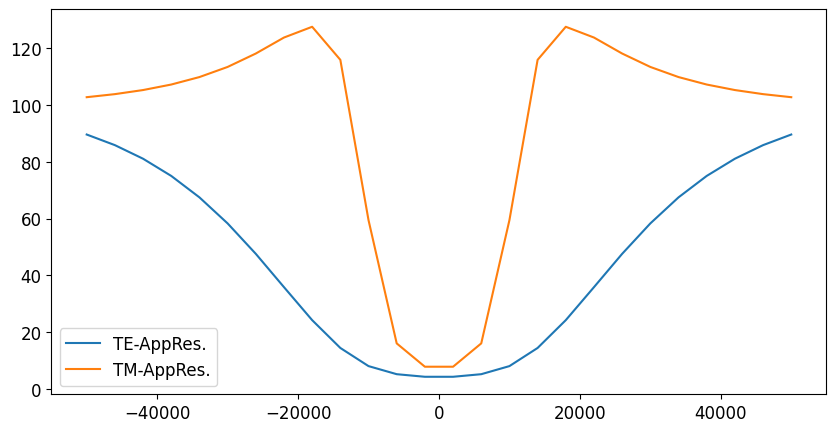

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
i_freq = 0
ax1.plot(rx_locs[:,0], rho_app_te[i_freq,:], '-', label='TE-AppRes.', color='C0')
ax1.plot(rx_locs[:,0], rho_app_tm[i_freq,:], '-', label='TM-AppRes.', color='C1')
# ax1.set_ylim(50, 2e2) 
ax1.legend()

Text(0.5, 0, 'Period (s)')

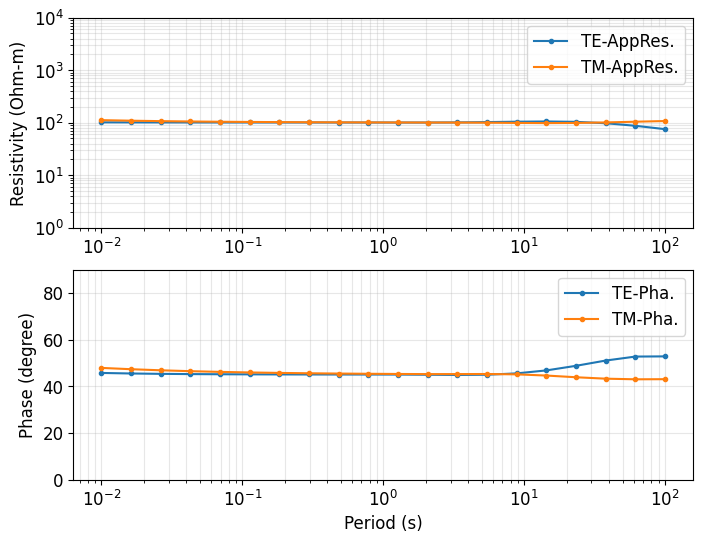

In [32]:
i_sounding = 3
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
ax1, ax2 = axs
ax1.loglog(1./frequencies, rho_app_te[:,i_sounding], '.-', label='TE-AppRes.')
ax1.loglog(1./frequencies, rho_app_tm[:,i_sounding], '.-', label='TM-AppRes.')
ax1.legend()
ax1.set_ylim(1, 1e4)

ax2.semilogx(1./frequencies, phase_te[:,i_sounding], '.-', label='TE-Pha.')
ax2.semilogx(1./frequencies, phase_tm[:,i_sounding]+180, '.-', label='TM-Pha.')
ax2.set_ylim(0, 90)
ax2.legend()
for ax in axs:
    ax.grid(True, which='both', alpha=0.3)
ax1.set_ylabel("Resistivity (Ohm-m)")
ax2.set_ylabel("Phase (degree)")
ax2.set_xlabel('Period (s)')

In [33]:
noise_rho_app_te = 0.05 * abs(rho_app_te) * np.random.randn(len(frequencies), n_rx)
noise_rho_app_tm = 0.05 * abs(rho_app_tm) * np.random.randn(len(frequencies), n_rx)
noise_phase_te = 2 * np.ones_like(phase_te) * np.random.randn(len(frequencies), n_rx)
noise_phase_tm = 2 * np.ones_like(phase_tm) * np.random.randn(len(frequencies), n_rx)

In [34]:
# This could have been better if we could use MTpy
import dill 
output_results ={
    'rx_locs': rx_locs,
    'frequencies': frequencies,
    'app_rho_te': rho_app_te+noise_rho_app_te,
    'app_rho_tm': rho_app_tm+noise_rho_app_tm,
    'phase_te': phase_te+noise_phase_te,
    'phase_tm': phase_tm+noise_phase_tm,
    'mesh': mesh,
    'sigma': sigma
}
dill.dump(output_results, open("../data/synthetic_2d.pik", "wb"))

## Step 5: Create `MTpy` object and save as `MTH5` format

In [35]:
# import numpy as np
# from mtpy import MTCollection
# from mtpy import MT
# from mtpy.core.z import Z
# mc = MTCollection()
# mc.open_collection(filename="./2d_mth5.h5")

# for i_rx in range(n_rx):
#     app_rho_matrix = np.zeros((n_freq, 2, 2), dtype=float)
#     phase_matrix = np.zeros((n_freq, 2, 2), dtype=float)
#     app_rho_matrix[:,0,1] = output_results['app_rho_te'][:,i_rx]
#     app_rho_matrix[:,1,0] = output_results['app_rho_tm'][:,i_rx]
#     phase_matrix[:,0,1] = output_results['phase_te'][:,i_rx]
#     phase_matrix[:,1,0] = output_results['phase_tm'][:,i_rx]
#     # or add apparent resistivity and phase
#     z_object = Z()
#     z_object.set_res_phase(app_rho_matrix, phase_matrix, frequencies)

#     dx_lon = d_station / 1e5

#     response = MT()  
#     response.Z = z_object

#     response.survey_metadata.id = "model_2d_response"
#     response.station_metadata.id = "mt-{:d}".format(i_rx)
#     response.station_metadata.transfer_function.id = "mt-{:d}".format(i_rx)
#     # if this is 2D maybe we need a location
#     response.station_metadata.location.latitude = 40 
#     response.station_metadata.location.longitude = -122 + dx_lon * (i_rx)
#     mc.add_tf(response)
# mc.close_collection()

GDAL_DATA environment variable is not set  Please see https://trac.osgeo.org/gdal/wiki/FAQInstallationAndBuilding#HowtosetGDAL_DATAvariable 
2022-10-16 21:27:09,153 [line 135] error.get_mtpy_logger - INFO: Logging file can be found C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\mtpy-2.0.0-py3.9.egg\logs\mtpy_error.log


Ignore GDAL as it is not working. Will use pyproj


C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: -PKG-VERSION is an invalid version and will not be supported in a future release
  warnings.warn(
2022-10-16 21:27:10,880 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\mth5-0.3.0-py3.9.egg\logs\mth5_debug.log
2022-10-16 21:27:15,558 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing 2d_mth5.h5
